# Data filters

## Auxiliary functions

In [1]:
function z = get_rnd_data()
    % Creates data for the example.
    w = 0.0 + 3.0 * randn(1, 1);
    z = 15.0 + w;
endfunction

In [2]:
function h = get_sample01()
    % Loads 'sample01.mat'.
    persistent sample01
    persistent first_call
    persistent k

    if isempty(first_call)
        % Initial `measure`.
        load data/note-000-filters-octave-sample01;

        % Flag started.
        first_call = 1;
        
        % Step counter.
        k = 1;
    end

    % Get next element.
    h = sample01(k);
    k = k + 1;
endfunction

## Average filter

In [3]:
function avg = filter_avg(y_2)
    % Recursive average filter.
    persistent x_1
    persistent first_call
    persistent k

    if isempty(first_call)
        % Initial `measure`.
        x_1 = 0;

        % Flag started.
        first_call = 1;
        
        % Step counter.
        k = 1;
    end

    alpha = (k - 1) / k;
    avg = alpha * x_1 + (1 - alpha) * y_2;

    x_1 = avg;
    k = k + 1;
endfunction

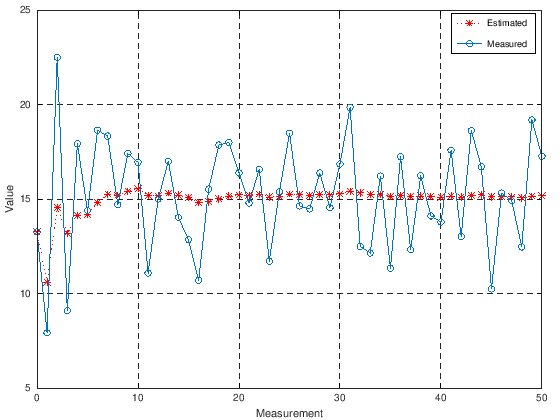

In [4]:
% Time points to make evaluation.
times = 0:1:50;

% Allocate intermediate storage.
n_samples = length(times);
x_hat = zeros(n_samples, 1);
y_val = zeros(n_samples, 1); 

% Simulate data acquisition.
for k = 1:n_samples
    y_t = get_rnd_data();
    x_t = filter_avg(y_t);
    x_hat(k) = x_t;
    y_val(k) = y_t;
end

h = figure('visible', 'off');
plot(times, x_hat, 'r:*');
hold on;
plot(times, y_val, 'o-');
grid on;
set(gca, 'GridLineStyle', '--');
xlabel('Measurement');
ylabel('Value');
legend('Estimated', 'Measured');

## Rolling mean filter

In [5]:
function avg = filter_rolling(y_2)
    % Recursive average filter.
    persistent x_1
    persistent first_call
    persistent k
    persistent n
    persistent ybuf

    if isempty(first_call)
        % Initialize buffer.
        n = 10;
        ybuf = y_2 * ones(n + 1, 1);
    
        % Initial `measure`.
        x_1 = y_2;

        % Flag started.
        first_call = 1;
        
        % Step counter.
        k = 1;
    end

    % Update buffer.
    for m = 1:n
        ybuf(m) = ybuf(m+1);
    end

    ybuf(n+1) = y_2;

    % Compute average.
    avg = x_1 + (y_2 - ybuf(1)) / n;
    x_1 = avg;
endfunction

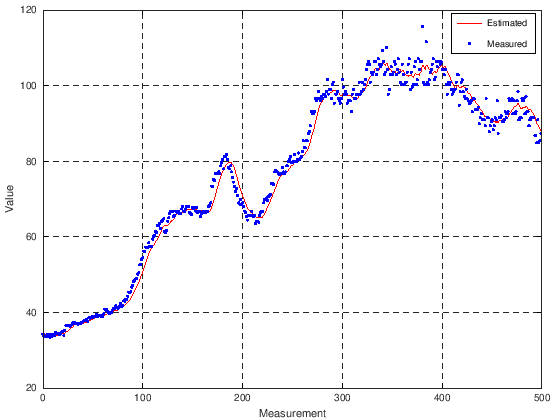

In [6]:
% Allocate intermediate storage.
n_samples = 500;
x_hat = zeros(n_samples, 1);
y_val = zeros(n_samples, 1);

% Simulate data acquisition.
for k = 1:n_samples
    y_t = get_sample01();
    x_t = filter_rolling(y_t);
    x_hat(k) = x_t;
    y_val(k) = y_t;
end

dt = 1;
tend = (n_samples - 1) * dt;
times = 0:dt:tend;

h = figure('visible', 'off');
plot(times, x_hat, 'r-');
hold on;
plot(times, y_val, 'b.');
grid on;
set(gca, 'GridLineStyle', '--');
xlabel('Measurement');
ylabel('Value');
legend('Estimated', 'Measured');

## Low pass filter

In [7]:
function x_lpf = filter_low_pass(y_2, alpha)
    % Low-pass filter.
    persistent x_1
    persistent first_call

    if isempty(first_call)   
        % Initial `measure`.
        x_1 = y_2;

        % Flag started.
        first_call = 1;
    end

    % Filter data.
    x_lpf = alpha * x_1 + (1 - alpha) * y_2;
    x_1 = x_lpf;
endfunction

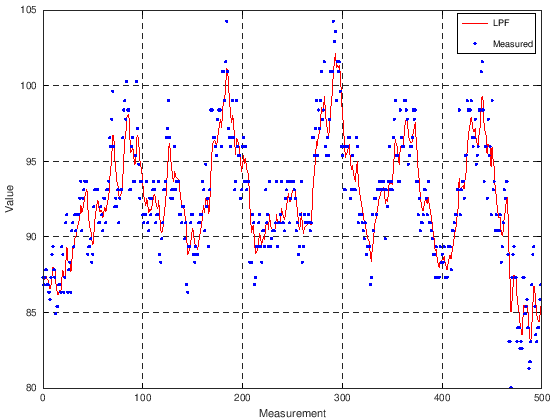

In [8]:
% Allocate intermediate storage.
n_samples = 500;
x_hat = zeros(n_samples, 1);
y_val = zeros(n_samples, 1);

% Simulate data acquisition.
for k = 1:n_samples
    y_t = get_sample01();
    x_t = filter_low_pass(y_t, 0.7);
    x_hat(k) = x_t;
    y_val(k) = y_t;
end

dt = 1;
tend = (n_samples - 1) * dt;
times = 0:dt:tend;

h = figure('visible', 'off');
plot(times, x_hat, 'r-');
hold on;
plot(times, y_val, 'b.');
grid on;
set(gca, 'GridLineStyle', '--');
xlabel('Measurement');
ylabel('Value');
legend('LPF', 'Measured');

## Kalman filter

In [9]:
function [volt Px K] = filter_kalman(z)
    % Simple Kalman filter.
    persistent A H Q R 
    persistent x P
    persistent first_call

    if isempty(first_call)
        % Initial `measure`.
        A = 1;
        H = 1;
        
        Q = 0;
        R = 4;

        x = 14;
        P =  6;

        % Flag started.
        first_call = 1;
    end
    
    % Predict dynamics.
    xp = A * x;
    Pp = A * P * A' + Q;

    % Compute gain from dynamics covariance.
    K = Pp * H' * inv(H * Pp * H' + R);

    % Add new measurement to priori.
    x = xp + K * (z - H * xp);
    P = Pp - K * H * Pp;

    volt = x;
    Px = P;
endfunction

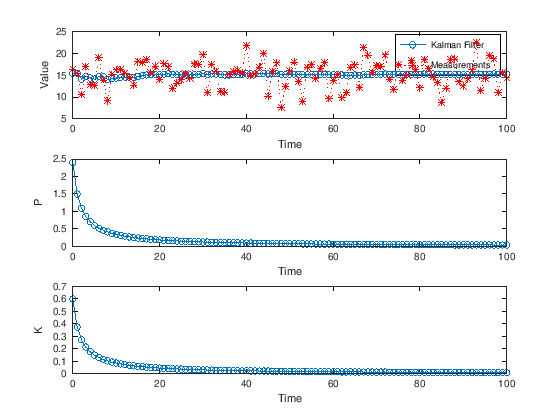

In [10]:
% Time points to make evaluation.
times = 0:1:100;

% Allocate intermediate storage.
n_samples = length(times);
x_hat = zeros(n_samples, 3);
y_val = zeros(n_samples, 1); 

% Simulate data acquisition.
% clear get_rnd_data;

for k = 1:n_samples
    y_t = get_rnd_data();
    [x_t, P, K] = filter_kalman(y_t);
    x_hat(k, :) = [x_t, P, K];
    y_val(k) = y_t;
end

h = figure('visible', 'off');
subplot(3, 1, 1)
plot(times, x_hat(:, 1), 'o-');
hold on;
plot(times, y_val, 'r:*') 
xlabel('Time')
ylabel('Value')
legend('Kalman Filter', 'Measurements')

subplot(3, 1, 2)
plot(times, x_hat(:, 2), 'o-');
xlabel('Time')
ylabel('P')

subplot(3, 1, 3)
plot(times, x_hat(:, 3), 'o-');
xlabel('Time')
ylabel('K')